## 2017314461 Muhammad Shakeel Zuhaib
Homework 6 (AI Porject)

CIFAR 10 with CNN

In [0]:
#Headers Definition
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import random
import time

###Loading and splitting the data (Train/ Test/ Validate):

In [4]:
#Transformations
transform = transforms.Compose([      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                     ]) #normalize each channel =>image = (image - mean) / std

transform_test = transforms.Compose([ transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                     ]) #normalize each channel =>image = (image - mean) / std

                  


#loading the data and preprocessing it
CIFAR_train= torchvision.datasets.CIFAR10("./data",train=True, download=True, transform=transform) #Training Data
CIFAR_test= torchvision.datasets.CIFAR10("./data",train=False, download=True, transform=transform_test) #Testing Data

#Create Validation Set
indices = list(range(len(CIFAR_train)))
seed=30
np.random.seed(seed)
np.random.shuffle(indices)

split = int(np.floor(0.9 * len(CIFAR_train)))
tr_idx, val_idx = indices[:split], indices[split:]

tr_sampler = SubsetRandomSampler(tr_idx)
val_sampler = SubsetRandomSampler(val_idx)
 

#How are we gonna iterate over the data?
train_loader= torch.utils.data.DataLoader(CIFAR_train,batch_size=128,sampler=tr_sampler,num_workers=2) #batch_size : process the data in batches and make a better generalization
valid_loader= torch.utils.data.DataLoader(CIFAR_train,batch_size=128,sampler=val_sampler,num_workers=2)
test_loader= torch.utils.data.DataLoader(CIFAR_test,batch_size=128,shuffle=False,num_workers=2)  #shuffling the data makes a better generalization

# data labels
labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#each data has 4 images

Files already downloaded and verified
Files already downloaded and verified


###This cell is only for checking the visuals for one picture (You can skip this): 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])
dog


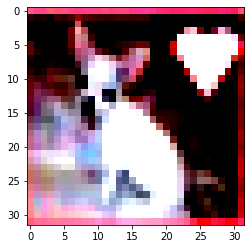

In [11]:
import matplotlib.pyplot as plt
import numpy as np

#every type you run this it is shuffled
for data in train_loader:
  print(data[0].shape)  # batch_size, # channels, #height, #width
  break

#Every data is a list of: 1.#(batch_size)images   2.#(batch_size)labels

# show images
plt.imshow(np.transpose(data[0][0], (1, 2, 0))) #replace 0 with 1 axis and 1 with 2 and 2 with 0  -> output: height,width ,channel
plt.show
print(labels[data[1][0]])

###Neural Network Definition:

In [0]:
class Net(nn.Module):
  #initialize your network strucutre
  def __init__(self):
    super().__init__() 

    #Conv2d Parameters: input channels,output channels, size_kernel
    #BatchNorm Goals: Normalize the outputs, parameters:(#output_channels/ node)

    self.conv1a = nn.Conv2d(3, 32, 3,padding=1)
    self.bn1a = nn.BatchNorm2d(32)      
    self.conv1b = nn.Conv2d(32, 64, 3,padding=1)
    self.bn1b = nn.BatchNorm2d(64)   
    self.pool1 = nn.MaxPool2d(2, 2)   



    self.conv2a = nn.Conv2d(64, 128, 3,padding=1)
    self.bn2a = nn.BatchNorm2d(128)
    self.conv2b = nn.Conv2d(128, 128, 3,padding=1)
    self.bn2b = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(2, 2)
  

    self.conv3a = nn.Conv2d(128, 256, 3,padding=1)
    self.bn3a = nn.BatchNorm2d(256)
    self.conv3b = nn.Conv2d(256, 256, 3,padding=1)
    self.bn3b = nn.BatchNorm2d(256)
    self.pool3 = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(4096, 512)
    self.bn4 = nn.BatchNorm1d(512)    #Goal Normalize the outputs, parameters:(#output_nodes)

    self.fc2 = nn.Linear(512, 128)
    self.bn5 = nn.BatchNorm1d(128)

    self.fc3 = nn.Linear(128, 10) 

  #define your network inner functions  
  def forward(self,x):
    x = self.pool1(F.relu(self.bn1b(self.conv1b(self.bn1a(self.conv1a(x))))))  # Convolution -> Normalize -> threshold/activation(optional) -> Convolution  -> Normalize ->threshold/activation -> pooling
    x = self.pool2(F.relu(self.bn2b(self.conv2b(self.bn2a(self.conv2a(x))))))
    x = self.pool3(F.relu(self.bn3b(self.conv3b(self.bn3a(self.conv3a(x))))))  
    #flatten
    x = x.view(-1, 4096)
    x = F.relu(self.bn4(self.fc1(x))) # input,connection_weight -> Normalize -> threshold/activation
    x = F.relu(self.bn5(self.fc2(x)))
    x = self.fc3(x)
    return x
    #this function will return for each picture: 10 nodes (prediction value of each label)

###Driver Code:

In [14]:
# Select GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("This model is running on" , torch.cuda.get_device_name())

#Model
net=Net().to(device)

#Get adjustable parameters(weights) and optimize them 
optimizer=optim.Adam(net.parameters(),lr=0.001,weight_decay=0.0001) #weight decay is multiplied to weight to prevent them from growing too large

#Error Function
criterion = nn.CrossEntropyLoss() 

# Learning rate scheduler: adjusts learning rate as the epoch increases
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) #Decays the learning rate by multiplyin by gamma every step_size epochs

#How many times we pass our full data (the same data)
total_epoch=50 

cuda:0
This model is running on Tesla K80


###Training and Validation:

In [16]:
best_valid_acc=0

for cur_epoch in range(total_epoch):
  train_correct=0
  train_total=0
  train_loss=0 #loss per epoch

  valid_correct=0
  valid_total=0
  valid_loss=0 #loss per epoch
  
  net.train() #put the model in training mode
  for data in train_loader:

    #every data consits of (batch_size) images
    X,y=data[0].to(device), data[1].to(device) #picture(X batch_size), label(X batch_size) -> #batch size comes first #note that the label here is a number which is index in labels list
    
    net.zero_grad()  
    output = net(X)  
    loss = criterion(output, y) #calculate the error/ loss for the that batch (data)

    loss.backward()  #computes dloss/dw for every parameter w  (loss for every parameter)
    optimizer.step() #update weights
    train_loss+=loss.item()

    #calculate how many right do you have in every training data until the end of all training datas
    #output is Batch_size*10 tensor
    for k, i in enumerate(output): # the output is batch_size* 10 tensor   # k is the index of the data # i the data itself
        if torch.argmax(i) == y[k]: # in every row find the highest prediction index and compare it to y[k]
                train_correct += 1
        train_total += 1

  exp_lr_scheduler.step() #learning rate adjustment
  
  net.eval() #put the model in evaluation mode
  #validate for each epoch
  with torch.no_grad(): # no gradient
    for data in valid_loader:
      X, y = data[0].to(device), data[1].to(device) # store the images in X and labels in y
      output = net(X) 
      loss = criterion(output, y)

      valid_loss += loss.item()

      for k, i in enumerate(output): # the output is batch_size* 10 ARRAY
          if torch.argmax(i) == y[k]: # in every row find the highest prediction and comprae its index
              valid_correct += 1
          valid_total += 1
  
  #if the model is better than the previous best store it
  if((valid_correct/valid_total)>best_valid_acc):
    best_valid_acc= (valid_correct/valid_total)
    torch.save(net.state_dict(), "./save_best.pth") #save early stopping point

  print(' Epoch {}/{}: Training Accuracy {} |  Training Loss {} || Validation Accuracy {} |  Validation Loss {}'.format(cur_epoch+1, total_epoch, train_correct/train_total,train_loss/len(train_loader),valid_correct/valid_total,valid_loss/len(valid_loader))) #accuray for each epoch
  print(' Best validation so far {}'.format(best_valid_acc))
  print('-------------------------------------------------------------------------------------------------------------------------------')

 Epoch 1/50: Training Accuracy 0.93 |  Training Loss 0.20097630164078015 || Validation Accuracy 0.843 |  Validation Loss 0.501394622772932
 Best validation so far 0.843
-------------------------------------------------------------------------------------------------------------------------------
 Epoch 2/50: Training Accuracy 0.9336888888888889 |  Training Loss 0.189052396051755 || Validation Accuracy 0.8326 |  Validation Loss 0.5541829496622086
 Best validation so far 0.843
-------------------------------------------------------------------------------------------------------------------------------
 Epoch 3/50: Training Accuracy 0.9401333333333334 |  Training Loss 0.17612645063887944 || Validation Accuracy 0.841 |  Validation Loss 0.5217827565968036
 Best validation so far 0.843
-------------------------------------------------------------------------------------------------------------------------------
 Epoch 4/50: Training Accuracy 0.9393111111111111 |  Training Loss 0.17308179625

###Testing:

In [17]:
#load the best validation accuracy model so far
load_model = Net().to(device)
load_model.load_state_dict(torch.load("./save_best.pth")) 

load_model.eval()

correct =0
total=0
with torch.no_grad(): # no gradient
  for data in test_loader:
      X, y = data[0].to(device), data[1].to(device) # store the images in X and labels in y
      output = load_model(X) #send the 4 images
      #print(output)
      for k, i in enumerate(output): # the output is 4* 10 ARRAY
          if torch.argmax(i) == y[k]: # in every row find the highest prediction and comprae its index
              correct += 1
          total += 1

print("Test Accuracy: ", correct/total)

Test Accuracy:  0.8715
